 **Dự án:** Phân tích cảm xúc bình luận Tiếng Việt với PhoBERT và LLM Evaluation

**Mô hình:** Fine-tuning PhoBERT-base

**Bài toán:** Phân loại tích cực (pos), trung lập (neu), tiêu cực (neg)

**Điểm nổi bật dự án:**
  * Tăng cường dữ liệu (data Augmentation): Sử dụng gemini để sinh dữ liệu nhân tạo để xử lý dữ liệu mất cân bằng.
  * Fine-tuning Pre-trained Model: Tinh chỉnh mô hình PhoBERT để đạt hiệu suất cao trên dữ liệu đặc thù của thương mại điện tử.
  * Đánh giá bằng LLM: Xây dựng quy trình "AI giám khảo AI": Sử dụng Gemini để phân tích định tính các trường hợp mô hình dự đoán sai, từ đó tìm ra nguyên nhân gốc rễ.


#**Import thư viện**

In [20]:
!pip install transformers

In [21]:
from google.colab import drive
import re
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import getpass
import seaborn as sns
import httpx
import json
import random
import os
import time
import requests
import json
import asyncio
!pip install httpx
import httpx

#**Cấu hình**

In [22]:
MODEL_NAME = "vinai/phobert-base"
FILE = "data_cleaned.csv"
NUM_EPOCHS = 5
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
SAMPLE_SIZE = None
BEST_MODEL_PATH = "/content/drive/MyDrive/NLP/encoder-only/my_best_encoder_model"
BEST_MODEL_PATH1 = "/content/drive/MyDrive/NLP/encoder-only/my_best_encoder_model1"


TRAIN_CSV = "train_data.csv"
VAL_CSV = "val_data.csv"
TEST_CSV = "test_data.csv"
target_names = ['POS', 'NEU', 'NEG']

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
  print(f"Ten GPU: {torch.cuda.get_device_name(0)}")

cuda
Ten GPU: Tesla T4


#**Kết nối Google Drive**

In [23]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#**Xử lý dữ liệu**

In [25]:
def clean_data(
    file_path,
    output_path="data_cleaned.csv",
    min_comment_length=2,
    label_map={'NEG': 0, 'NEU': 1, 'POS': 2}
):
    # Đọc file gốc
    df = pd.read_csv(file_path)

    df = df.drop(columns=['Unnamed: 3'], errors='ignore')
    # Xoá duplicate
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    duplicates_removed = initial_rows - df.shape[0]

    # Xử lý comment
    df['comment'] = df['comment'].astype(str)
    mask = df['comment'].str.strip().str.len() > min_comment_length

    before_filter = df.shape[0]
    df = df[mask]
    short_comments_removed = before_filter - df.shape[0]

    # Gán label_id nếu có cột 'label'
    if 'label' in df.columns:
        df['label_id'] = df['label'].map(label_map)

    # Xuất file
    df.to_csv(output_path, index=False)

    stats = {
        "initial_rows": initial_rows,
        "duplicates_removed": duplicates_removed,
        "short_comments_removed": short_comments_removed,
        "final_rows": df.shape[0]
    }

    return df, stats


##**Dữ liệu gốc**

In [26]:
df, stats = clean_data("/content/drive/MyDrive/NLP/encoder-only/data.csv")
print(stats)
df['label_id'] = df['label_id'].astype(int)
cols_to_keep = ['comment', 'label_id']
df.head(15)

{'initial_rows': 31460, 'duplicates_removed': 3982, 'short_comments_removed': 20, 'final_rows': 27458}


,comment,label,rate,label_id
0,Áo bao đẹp ạ!!,POS,5,2
1,Tuyệt vời !,POS,5,2
2,2day ao khong giong trong.,NEG,1,0
3,"Mùi thơm,bôi lên da mềm da.",POS,5,2
4,"Vải đẹp, dày dặn.",POS,5,2
5,"Hàng rất đẹp, rất chi là ưng ý.",POS,5,2
6,"Chất lượng sản phẩm tốt, date dài.",POS,5,2
7,Ăn nói và thái độ phục vụ tốt.,POS,4,2
8,Đóng gói sản phẩm chắc chắn.,POS,5,2
9,tất sờn hết ca chưa dùng mà vay r.,NEG,2,0


##**Vẽ biểu đồ cột**

In [28]:
def plot_label_distribution(df, label_column='label'):
    # Đếm số lượng mỗi nhãn
    label_counts = df[label_column].value_counts()

    # Chuẩn bị data cho sns
    data_to_plot = label_counts.reset_index()
    data_to_plot.columns = ['label', 'count']

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        x="label",
        y="count",
        data=data_to_plot,
        order=label_counts.index
    )

    # Ghi số lên từng cột
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.0f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )

    plt.title("Phân bố nhãn (Số lượng)", fontsize=16)
    plt.xlabel("Nhãn (Label)", fontsize=12)
    plt.ylabel("Số lượng (Count)", fontsize=12)
    plt.show()


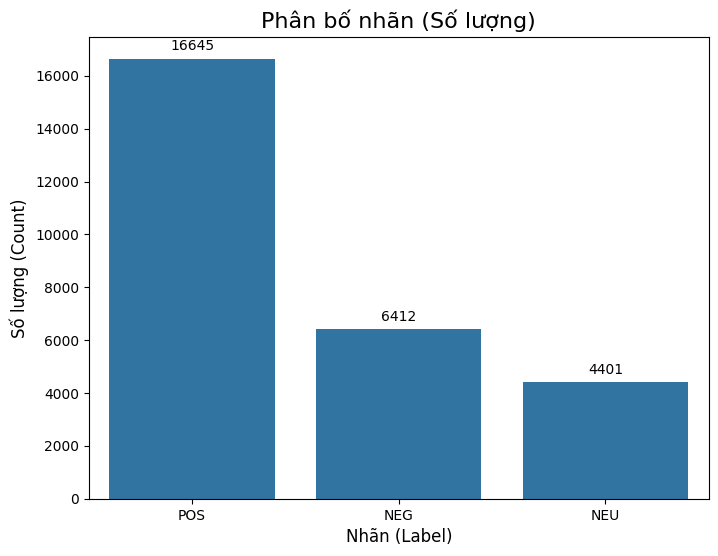

In [29]:
plot_label_distribution(df, label_column='label')

#**Khởi tạo Model và Tokenizer**

In [30]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config = config
)

model1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config = config
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#**Xây dựng Class SentimentDataset**

In [31]:
class SentimentDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels =labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__ (self):
    return len(self.texts)

  def __getitem__ (self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
    }

#**Chia tập dữ liệu thành train(80%), val(10%), test(10%)**

In [32]:
df_train, df_temp = train_test_split(df, test_size = 0.2,
                                     random_state = 42,
                                     stratify = df['label_id'])
df_val, df_test = train_test_split(df_temp,
                                   test_size = 0.5,
                                   random_state = 42,
                                   stratify=df_temp['label_id'])

print("Kích thước tập Train: ", len(df_train))
print("Kích thước tập Val: ", len(df_val))
print("Kích thước tập Test: ", len(df_test))

Kích thước tập Train:  21966
Kích thước tập Val:  2746
Kích thước tập Test:  2746


#**Thiết lập Dataset và DataLoader**

In [33]:
train_texts = df_train['comment'].to_numpy()
train_labels = df_train['label_id'].to_numpy()

val_texts = df_val['comment'].to_numpy()
val_labels = df_val['label_id'].to_numpy()

test_texts = df_test['comment'].to_numpy()
test_labels = df_test['label_id'].to_numpy()

df_train.to_csv(TRAIN_CSV, index = False)
df_val.to_csv(VAL_CSV, index = False)
df_test.to_csv(TEST_CSV, index = False)



train_dataset = SentimentDataset(
    texts = train_texts,
    labels = train_labels,
    tokenizer = tokenizer,
    max_len = MAX_LENGTH
)

val_dataset = SentimentDataset(
    texts = val_texts,
    labels = val_labels,
    tokenizer = tokenizer,
    max_len = MAX_LENGTH
)

test_dataset = SentimentDataset(
    texts = test_texts,
    labels = test_labels,
    tokenizer = tokenizer,
    max_len = MAX_LENGTH
)

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle= False
)




# dữ liệu gốc
y_train = df_train['label_id'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float)
weights_tensor = weights_tensor.to(device)



print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1373
172
172


#**Tạo dữ liệu nhân tạo**

In [ ]:
# --- CẤU HÌNH API ---
if "GEMINI_API_KEY" not in os.environ:
    os.environ["GEMINI_API_KEY"] = getpass.getpass("Nhập Google Gemini API Key: ")


MODEL_ID = "gemini-2.5-flash-lite"
ENDPOINT = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_ID}:generateContent?key={API_KEY}"

# --- HÀM GỌI GEMINI ---
def call_gemini_paraphrase(text):
    system_prompt = """
    Bạn là một trợ lý AI chuyên tạo dữ liệu huấn luyện NLP tiếng Việt.
    Nhiệm vụ: Viết lại (paraphrase) câu bình luận dưới đây sao cho:
    1. Giữ nguyên hoàn toàn ý nghĩa và cảm xúc (Tích cực/Tiêu cực/Trung lập) của câu gốc.
    2. Thay đổi từ vựng, cấu trúc câu, sử dụng văn phong tự nhiên của người mua hàng trên Shopee/Lazada/Tiktok.
    3. Có thể dùng teencode nhẹ (ko, dc, ok, rùi...) để tăng tính thực tế.
    4. CHỈ TRẢ VỀ CÂU MỚI, không bao gồm dấu ngoặc kép, không giải thích thêm.
    """

    payload = {
        "contents": [{"role": "user", "parts": [{"text": f"Câu gốc: {text}\nViết lại:"}]}],
        "system_instruction": {"parts": [{"text": system_prompt}]},
        "generation_config": {
            "temperature": 0.9,
            "max_output_tokens": 100,
        }
    }

    for attempt in range(3): # Thử lại 3 lần
        try:
            with httpx.Client(timeout=30) as client:
                response = client.post(ENDPOINT, json=payload, headers={"Content-Type": "application/json"})

            if response.status_code == 200:
                data = response.json()
                if "candidates" in data and data["candidates"]:
                    return data["candidates"][0]["content"]["parts"][0]["text"].strip()
            elif response.status_code == 429:
                print(f"Bị giới hạn Rate Limit (429). Đang đợi 10s... (Lần {attempt+1})")
                time.sleep(10) # Đợi lâu hơn nếu bị chặn
            else:
                print(f"Lỗi API {response.status_code}: {response.text}")
                return None # Lỗi khác thì bỏ qua luôn

        except Exception as e:
            print(f"Lỗi kết nối: {e}")
            time.sleep(1)
    return None

# --- QUY TRÌNH SINH DỮ LIỆU ---

if 'df_train' not in locals():
    print("CẢNH BÁO: Biến df_train chưa được định nghĩa. Hãy chạy cell split data trước!")
else:
    target_labels = [0, 1] # NEG và NEU


    samples_per_label = 500

    new_data = []

    print("--- BẮT ĐẦU SINH DỮ LIỆU (PARAPHRASING) ---")

    for label_id in target_labels:
        source_comments = df_train[df_train['label_id'] == label_id]['comment'].tolist()

        if len(source_comments) > 0:
            # Lấy mẫu có lặp lại (nếu số lượng gốc ít hơn số cần sinh)
            comments_to_process = random.choices(source_comments, k=samples_per_label)

            print(f"\n>> Đang xử lý nhãn {label_id} ({len(comments_to_process)} mẫu)...")

            # Dùng tqdm để hiện thanh tiến trình
            for original_text in tqdm(comments_to_process):
                paraphrased_text = call_gemini_paraphrase(original_text)

                if paraphrased_text:
                    clean_text = paraphrased_text.replace('"', '').replace("'", "").strip()
                    new_data.append({
                        'comment': clean_text,
                        'label_id': label_id
                    })

                time.sleep(4)

    # --- LƯU KẾT QUẢ ---
    if new_data:
        df_synthetic_safe = pd.DataFrame(new_data)
        df_synthetic_safe = df_synthetic_safe[df_synthetic_safe['comment'].str.len() > 5]

        print(f"\nHoàn tất! Đã sinh được {len(df_synthetic_safe)} mẫu.")
        print(df_synthetic_safe['label_id'].value_counts())

        df_synthetic_safe.to_csv("synthetic_data_safe.csv", index=False)
        print("Đã lưu vào file 'synthetic_data_safe.csv'")
        print(df_synthetic_safe.head())
    else:
        print("\nKhông sinh được dữ liệu nào. Hãy kiểm tra lại API Key hoặc df_train.")

#**Xây dựng các hàm đánh giá bằng gemini**

In [71]:
# @title

if "GEMINI_API_KEY" not in os.environ:
    os.environ["GEMINI_API_KEY"] = getpass.getpass("Nhập Google Gemini API Key: ")

API_KEY = os.environ["GEMINI_API_KEY"]
ENDPOINT = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?key={API_KEY}"

Nhập Google Gemini API Key: ··········


In [73]:
# @title
def call_gemini_for_scoring(system_prompt, user_prompt, max_attempts=3):
    """Gửi prompt chấm điểm đến API Gemini và yêu cầu trả về JSON."""

    # Trích xuất API Key từ ENDPOINT
    key_match = [part.split('=')[1] for part in ENDPOINT.split('?')[-1].split('&') if part.startswith('key=')]
    api_key = key_match[0] if key_match else None

    # Cấu trúc payload chuẩn cho API Gemini
    payload = {
        "contents": [{"role": "user", "parts": [{"text": user_prompt}]}],
        "system_instruction": {"parts": [{"text": system_prompt}]},
        "generation_config": {
            "response_mime_type": "application/json", # Yêu cầu định dạng JSON
        }
    }

    endpoint_base = ENDPOINT.split('?')[0]

    for attempt in range(max_attempts):
        try:
            with httpx.Client(timeout=45) as client:
                response = client.post(
                    f"{endpoint_base}?key={api_key}",
                    json=payload,
                    headers={"Content-Type": "application/json"}
                )

            if response.status_code == 200:
                data = response.json()

                if "candidates" in data and data["candidates"]:
                    text_content = data["candidates"][0]["content"]["parts"][0]["text"].strip()
                    try:
                        return json.loads(text_content)
                    except json.JSONDecodeError:
                        print(f"Lỗi phân tích JSON từ Gemini: {text_content[:100]}...")
                        return None
                return None

            elif response.status_code == 429:
                print(f"Rate limit – Đợi 10s...")
                time.sleep(10)

            else:
                print(f"API error: {response.status_code} - {response.text[:100]}...")
                return None

        except Exception as e:
            print(f"Lỗi kết nối/chung: {e}")
            time.sleep(2)

    return None

def get_test_predictions(model, data_loader, device):
    """Lấy dự đoán từ mô hình trên tập test và gán vào DataFrame."""

    # Tải lại mô hình tốt nhất và đặt chế độ đánh giá
    # model.load_state_dict(torch.load(BEST_MODEL_PATH)) # REMOVE THIS LINE
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating Predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Tải lại tập Test gốc để gắn kết quả
    df_test = pd.read_csv(TEST_CSV)
    df_test['true_label_id'] = all_labels
    df_test['predicted_label_id'] = all_preds

    return df_test

In [74]:
# @title
def llm_evaluate_classification(df_results, sample_size=30, random_seed=42):
    # 3.1. Lọc ra các trường hợp dự đoán SAI (Misclassified)
    df_misclassified = df_results[df_results['true_label_id'] != df_results['predicted_label_id']].copy()

    if len(df_misclassified) == 0:
        print("Mô hình quá tốt! Không có lỗi sai để đánh giá LLM.")
        return pd.DataFrame()

    # Chọn ngẫu nhiên N mẫu sai để chấm điểm LLM (Đánh giá trên mẫu nhỏ)
    n_samples = min(sample_size, len(df_misclassified))
    df_sample = df_misclassified.sample(n=n_samples, random_state=random_seed)

    # Định nghĩa bản đồ nhãn
    label_map_reverse = {0: "NEG (Tiêu cực)", 1: "NEU (Trung lập)", 2: "POS (Tích cực)"}

    llm_scores = []

    # --- PROMPT VÀ TIÊU CHÍ CHẤM ĐIỂM ---
    SYSTEM_PROMPT = "Bạn là chuyên gia phân loại cảm xúc. Nhiệm vụ của bạn là đánh giá lỗi sai của một mô hình AI."

    CRITERIA_PROMPT = (
        "Đánh giá lý do mô hình phân loại bị sai: \n"
        "1. Độ khó (1-5): Đánh giá độ khó của bình luận Gốc. (1: Rất dễ, 5: Rất khó/Mơ hồ). \n"
        "2. Lỗi do Dữ liệu/Mơ hồ (0/1): Nếu Độ khó >= 4 (Mơ hồ), gán 1 (Lỗi do Dữ liệu/Mơ hồ). Ngược lại, gán 0 (Lỗi do Mô hình).\n"
        "3. Lý do: Giải thích tại sao bình luận này gây nhầm lẫn hoặc tại sao mô hình sai sót.\n"
        "TRẢ LỜI ĐÚNG ĐỊNH DẠNG JSON: {'Độ_Khó': [1-5], 'Lỗi_Do_Dữ_Liệu': [0 hoặc 1], 'Lý_do': '...'}"
    )

    for _, row in tqdm(df_sample.iterrows(), desc=f"LLM Scoring ({n_samples} mẫu)"):
        comment = row['comment']
        true_label = label_map_reverse[row['true_label_id']]
        predicted_label = label_map_reverse[row['predicted_label_id']]

        user_prompt = f"""
            {CRITERIA_PROMPT}
            ---
            Bình luận Gốc: "{comment}"
            Nhãn Đúng (True Label): {true_label}
            Nhãn Mô hình Dự đoán (Predicted Label): {predicted_label}
        """

        score_result = call_gemini_for_scoring(SYSTEM_PROMPT, user_prompt)

        if score_result:
            score_result.update({
                'comment': comment,
                'true_label': true_label,
                'predicted_label': predicted_label
            })
            llm_scores.append(score_result)

    df_scored = pd.DataFrame(llm_scores)
    df_scored.to_csv("llm_evaluation_misclassified.csv", index=False)

    print("\n--- ĐÁNH GIÁ LLM HOÀN TẤT ---")
    print(f"Đã chấm điểm và lưu {len(df_scored)} mẫu vào 'llm_evaluation_misclassified.csv'.")

    return df_scored

#**Huấn luyện mô hình**

##**Hàm đánh giá mô hình**

In [38]:
# @title
def eval_model(model, data_loader, device, target_names):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(
        all_labels,
        all_preds,
        target_names=target_names,
        zero_division=0
    )
    print(f"Accuracy: {accuracy} - Report: {report}")
    return accuracy, report, avg_loss

##**Hàm huấn luyện mô hình**

In [39]:
# @title
def train(model, train_loader, val_loader, NUM_EPOCHS, optimizer, target_names, BEST_MODEL_PATH, class_weights):
    best_val_accuracy = 0.0

    # Khai báo hàm loss với trọng số
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        model.train()

        total_train_loss = 0
        correct_train_preds = 0
        total_samples = 0

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()

            # Gọi model không truyền labels để lấy logits thuần túy
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits

            # tính loss
            loss = criterion(logits, labels)

            total_train_loss += loss.item()

            _, preds = torch.max(logits, dim=1)
            correct_train_preds += torch.sum(preds == labels).item()
            total_samples += len(labels)

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train_preds / total_samples

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

        val_accuracy, val_report, val_loss = eval_model(model, val_loader, device, target_names)

        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_accuracy:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        # Lưu model tốt nhất
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.save_pretrained(BEST_MODEL_PATH)
            tokenizer.save_pretrained(BEST_MODEL_PATH)
            print("Lưu model thành công")

    return history

##**Hàm dự đoán**

In [40]:
# @title
def predict(text, model, tokenizer, device, MAX_LENGTH):
  model.eval()
  encoding = tokenizer.encode_plus(
      text,
      add_special_tokens = True,
      max_length = MAX_LENGTH,
      truncation = True,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt'
  )

  input_ids = encoding['input_ids'].to(device)
  attention_mask = encoding['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs.logits, dim = 1)


  if preds.item() == 0:
    return "Negative"
  elif preds.item() == 1:
    return "Neutral"
  else:
    return "Positive"

##**Hàm vẽ biểu đồ**

In [41]:
# @title
def plot_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.show()

#**Huấn luyện dữ liệu gốc**

##**Huấn luyện**

In [44]:
# Tạo trọng số cho 3 lớp
manual_weights_values = [1.2, 3.0, 0.8]
weights_tensor_manual = torch.tensor(manual_weights_values, dtype=torch.float).to(device)
# Load model gốc
model_original = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model_original.to(device)
# Tối ưu hóa
optimizer_original = AdamW(model_original.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.9405 | Train Acc: 0.5519


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7316096139839767 - Report:               precision    recall  f1-score   support

         POS       0.75      0.56      0.64       641
         NEU       0.35      0.56      0.43       440
         NEG       0.90      0.85      0.87      1665

    accuracy                           0.73      2746
   macro avg       0.67      0.65      0.65      2746
weighted avg       0.78      0.73      0.75      2746

Val Loss:   0.6064 | Val Acc:   0.7316
Lưu model thành công

Epoch 2/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.7793 | Train Acc: 0.6651


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7621995630007283 - Report:               precision    recall  f1-score   support

         POS       0.77      0.61      0.68       641
         NEU       0.38      0.49      0.43       440
         NEG       0.89      0.89      0.89      1665

    accuracy                           0.76      2746
   macro avg       0.68      0.66      0.67      2746
weighted avg       0.78      0.76      0.77      2746

Val Loss:   0.5815 | Val Acc:   0.7622
Lưu model thành công

Epoch 3/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.7239 | Train Acc: 0.7045


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.764748725418791 - Report:               precision    recall  f1-score   support

         POS       0.72      0.73      0.73       641
         NEU       0.39      0.49      0.44       440
         NEG       0.92      0.85      0.88      1665

    accuracy                           0.76      2746
   macro avg       0.68      0.69      0.68      2746
weighted avg       0.79      0.76      0.77      2746

Val Loss:   0.5751 | Val Acc:   0.7647
Lưu model thành công

Epoch 4/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.6995 | Train Acc: 0.7095


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.775673707210488 - Report:               precision    recall  f1-score   support

         POS       0.70      0.80      0.75       641
         NEU       0.42      0.42      0.42       440
         NEG       0.91      0.86      0.88      1665

    accuracy                           0.78      2746
   macro avg       0.68      0.69      0.68      2746
weighted avg       0.78      0.78      0.78      2746

Val Loss:   0.5715 | Val Acc:   0.7757
Lưu model thành công

Epoch 5/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.6719 | Train Acc: 0.7275


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7658412235979607 - Report:               precision    recall  f1-score   support

         POS       0.78      0.63      0.70       641
         NEU       0.39      0.53      0.45       440
         NEG       0.90      0.88      0.89      1665

    accuracy                           0.77      2746
   macro avg       0.69      0.68      0.68      2746
weighted avg       0.79      0.77      0.77      2746

Val Loss:   0.5734 | Val Acc:   0.7658


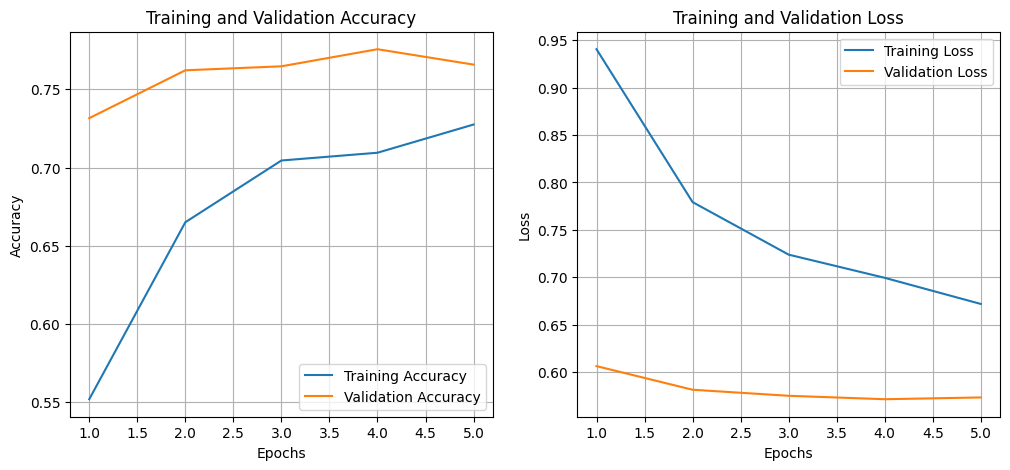

In [45]:
# Huấn luyện mô hình
history_original = train(
    model_original,
    train_loader,
    val_loader,
    NUM_EPOCHS,
    optimizer_original,
    target_names,
    BEST_MODEL_PATH,
    class_weights=weights_tensor_manual
)

# Vẽ biểu đồ
plot_history(history_original)

##**Tải model gốc**

In [46]:
tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

##**Đánh giá trên tập dữ liệu kiểm thử**

In [47]:
test_accuracy, test_report, _ = eval_model(
    model,
    test_loader,
    device,
    target_names
)

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n")
print(test_report)

Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7672978878368536 - Report:               precision    recall  f1-score   support

         POS       0.68      0.79      0.73       642
         NEU       0.41      0.39      0.40       440
         NEG       0.91      0.86      0.88      1664

    accuracy                           0.77      2746
   macro avg       0.66      0.68      0.67      2746
weighted avg       0.77      0.77      0.77      2746

Final Test Accuracy: 0.7673

Test Classification Report:

              precision    recall  f1-score   support

         POS       0.68      0.79      0.73       642
         NEU       0.41      0.39      0.40       440
         NEG       0.91      0.86      0.88      1664

    accuracy                           0.77      2746
   macro avg       0.66      0.68      0.67      2746
weighted avg       0.77      0.77      0.77      2746



##**Đánh giá bằng LLMs**

In [75]:
df_preds = get_test_predictions(model, test_loader, device)
llm_evaluation_results = llm_evaluate_classification(df_preds, sample_size=30)
print(llm_evaluation_results)

df_ket_qua = pd.read_csv("llm_evaluation_misclassified.csv")

excel_filename = "/content/drive/MyDrive/NLP/encoder-only/ket_qua_danh_gia_gemini.xlsx"
df_ket_qua.to_excel(excel_filename, index=False)

Generating Predictions:   0%|          | 0/172 [00:00<?, ?it/s]

LLM Scoring (30 mẫu): 0it [00:00, ?it/s]


--- ĐÁNH GIÁ LLM HOÀN TẤT ---
Đã chấm điểm và lưu 30 mẫu vào 'llm_evaluation_misclassified.csv'.
    Độ_Khó  Lỗi_Do_Dữ_Liệu                                              Lý_do  \
0        3               0  Mô hình đã không phân tích được cấu trúc câu v...   
1        4               1  Mô hình có thể đã tập trung vào mô tả chi tiết...   
2        4               1  Bình luận chứa cả cảm xúc tiêu cực về sản phẩm...   
3        4               1  Bình luận chứa từ viết tắt/lỗi chính tả không ...   
4        2               0  Mô hình đã không nhận diện được sắc thái tích ...   
5        4               1  Bình luận chứa hai vế đối lập: một vế tiêu cực...   
6        3               0  Mô hình đã nhầm lẫn giữa việc báo cáo một hành...   
7        2               0  Mô hình đã không phân biệt được đâu là yếu tố ...   
8        2               0  Mô hình đã không nhận diện được các từ ngữ man...   
9        3               0  Mô hình đã hiểu sai từ 'mần thịt' (làm thịt/gi...   
10       4 

#**Huấn luyện dữ liệu gốc + synthetic**

##**Đọc và làm sạch dữ liệu**

In [78]:
synthetic_path = "/content/drive/MyDrive/NLP/encoder-only/synthetic_data.csv"
df_synthetic, _ = clean_data(synthetic_path, output_path="data_cleaned_synthetic.csv")
df_synthetic['label_id'] = df_synthetic['label_id'].astype(int)
cols_to_keep = ['comment', 'label_id']
df_synthetic.head(5)


,comment,label_id
0,Shop gửi nhầm sz rùi ạ huhu 😭,0
1,Ốp bị xước nha shop,0
2,"Giá chát quá trời, shop khác rẻ hơn nhiều.",0
3,Ủa rồi sao ko thấy shop rep tin nhắn mình nữa ...,0
4,Áo này làm mình hơi hụt hẫng á :((,0


##**Chuẩn bị tài nguyên**

In [79]:
texts_syn = df_synthetic['comment'].to_numpy()
labels_syn = df_synthetic['label_id'].to_numpy()
dataset_syn = SentimentDataset(
    texts = texts_syn,
    labels = labels_syn,
    tokenizer =tokenizer,
    max_len = MAX_LENGTH)

loader_syn = DataLoader(
    dataset_syn,
    batch_size=BATCH_SIZE,
    shuffle=True)

# Dữ liệu gốc và synthetic
# synthetic data (GD1)
classes_syn = np.unique(labels_syn)
weights_syn = compute_class_weight(
    class_weight='balanced',
    classes=classes_syn,
    y=labels_syn)


weights_tensor_syn = torch.tensor(
    weights_syn,
    dtype=torch.float).to(device)

# Data gốc (GD2)
classes_real = np.unique(train_labels)
weights_real = compute_class_weight(class_weight='balanced',
                                    classes=classes_real,
                                    y=train_labels)
weights_tensor_real = torch.tensor(weights_real,
                                   dtype=torch.float).to(device)


##**Huấn luyện giai đoạn 1: dữ liệu giả lập**

In [55]:
model_2stage = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model_2stage.to(device)
optimizer_stage1 = AdamW(model_2stage.parameters(), lr=2e-5, weight_decay=0.01)

unique_labels_syn = np.unique(labels_syn)

current_weights = compute_class_weight(class_weight='balanced', classes=unique_labels_syn, y=labels_syn)

weights_syn_full = np.ones(3)

for i, label in enumerate(unique_labels_syn):
    weights_syn_full[label] = current_weights[i]

weights_tensor_syn_fixed = torch.tensor(weights_syn_full, dtype=torch.float).to(device)
print("Giai đoạn 1")
history_s1 = train(
    model_2stage,
    loader_syn,
    val_loader,
    NUM_EPOCHS=5,
    optimizer=optimizer_stage1,
    target_names=target_names,
    BEST_MODEL_PATH="/content/drive/MyDrive/NLP/encoder-only/best_model_stage1", # Lưu tạm vào đây
    class_weights=weights_tensor_syn_fixed # Use the fixed weights
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Giai đoạn 1

Epoch 1/5


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.7417 | Train Acc: 0.4972


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.2337946103423161 - Report:               precision    recall  f1-score   support

         POS       0.29      0.74      0.42       641
         NEU       0.15      0.38      0.22       440
         NEG       0.00      0.00      0.00      1665

    accuracy                           0.23      2746
   macro avg       0.15      0.37      0.21      2746
weighted avg       0.09      0.23      0.13      2746

Val Loss:   3.3854 | Val Acc:   0.2338
Lưu model thành công

Epoch 2/5


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.7038 | Train Acc: 0.5078


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.2327021121631464 - Report:               precision    recall  f1-score   support

         POS       0.23      1.00      0.38       641
         NEU       0.00      0.00      0.00       440
         NEG       0.00      0.00      0.00      1665

    accuracy                           0.23      2746
   macro avg       0.08      0.33      0.13      2746
weighted avg       0.05      0.23      0.09      2746

Val Loss:   3.8017 | Val Acc:   0.2327

Epoch 3/5


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.7006 | Train Acc: 0.5185


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.22432629278951202 - Report:               precision    recall  f1-score   support

         POS       0.28      0.63      0.38       641
         NEU       0.17      0.48      0.25       440
         NEG       0.00      0.00      0.00      1665

    accuracy                           0.22      2746
   macro avg       0.15      0.37      0.21      2746
weighted avg       0.09      0.22      0.13      2746

Val Loss:   4.1080 | Val Acc:   0.2243

Epoch 4/5


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.6970 | Train Acc: 0.5164


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.21267297887836853 - Report:               precision    recall  f1-score   support

         POS       0.37      0.43      0.40       641
         NEU       0.15      0.70      0.25       440
         NEG       0.00      0.00      0.00      1665

    accuracy                           0.21      2746
   macro avg       0.17      0.38      0.22      2746
weighted avg       0.11      0.21      0.13      2746

Val Loss:   4.2204 | Val Acc:   0.2127

Epoch 5/5


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.6837 | Train Acc: 0.5698


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.23197378004369992 - Report:               precision    recall  f1-score   support

         POS       0.45      0.52      0.48       641
         NEU       0.15      0.70      0.25       440
         NEG       0.00      0.00      0.00      1665

    accuracy                           0.23      2746
   macro avg       0.20      0.40      0.24      2746
weighted avg       0.13      0.23      0.15      2746

Val Loss:   4.0297 | Val Acc:   0.2320


##**Huấn luyện dữ liệu giai đoạn 2: Dữ liệu thật**

In [56]:
optimizer_stage2 = AdamW(model_2stage.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
print("Giai đoạn 2")
history_s2 = train(
    model_2stage,
    train_loader,
    val_loader,
    NUM_EPOCHS=5,
    optimizer=optimizer_stage2,
    target_names=target_names,
    BEST_MODEL_PATH=BEST_MODEL_PATH1,
    class_weights=weights_tensor_real
)

Giai đoạn 2

Epoch 1/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.8974 | Train Acc: 0.6240


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7545520757465404 - Report:               precision    recall  f1-score   support

         POS       0.66      0.81      0.73       641
         NEU       0.37      0.35      0.36       440
         NEG       0.91      0.84      0.87      1665

    accuracy                           0.75      2746
   macro avg       0.65      0.67      0.65      2746
weighted avg       0.77      0.75      0.76      2746

Val Loss:   0.6002 | Val Acc:   0.7546
Lưu model thành công

Epoch 2/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.7698 | Train Acc: 0.6949


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7643845593590677 - Report:               precision    recall  f1-score   support

         POS       0.74      0.73      0.74       641
         NEU       0.39      0.51      0.44       440
         NEG       0.92      0.84      0.88      1665

    accuracy                           0.76      2746
   macro avg       0.68      0.70      0.69      2746
weighted avg       0.79      0.76      0.78      2746

Val Loss:   0.5947 | Val Acc:   0.7644
Lưu model thành công

Epoch 3/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.7244 | Train Acc: 0.7146


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7782228696285506 - Report:               precision    recall  f1-score   support

         POS       0.70      0.82      0.76       641
         NEU       0.43      0.41      0.42       440
         NEG       0.91      0.86      0.88      1665

    accuracy                           0.78      2746
   macro avg       0.68      0.70      0.69      2746
weighted avg       0.78      0.78      0.78      2746

Val Loss:   0.5923 | Val Acc:   0.7782
Lưu model thành công

Epoch 4/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.6926 | Train Acc: 0.7354


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7767662053896577 - Report:               precision    recall  f1-score   support

         POS       0.77      0.70      0.73       641
         NEU       0.40      0.50      0.45       440
         NEG       0.90      0.88      0.89      1665

    accuracy                           0.78      2746
   macro avg       0.69      0.69      0.69      2746
weighted avg       0.79      0.78      0.78      2746

Val Loss:   0.5509 | Val Acc:   0.7768

Epoch 5/5


Training:   0%|          | 0/1373 [00:00<?, ?it/s]

Train Loss: 0.6654 | Train Acc: 0.7434


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7687545520757465 - Report:               precision    recall  f1-score   support

         POS       0.77      0.74      0.75       641
         NEU       0.40      0.55      0.46       440
         NEG       0.92      0.84      0.88      1665

    accuracy                           0.77      2746
   macro avg       0.69      0.71      0.70      2746
weighted avg       0.80      0.77      0.78      2746

Val Loss:   0.5870 | Val Acc:   0.7688


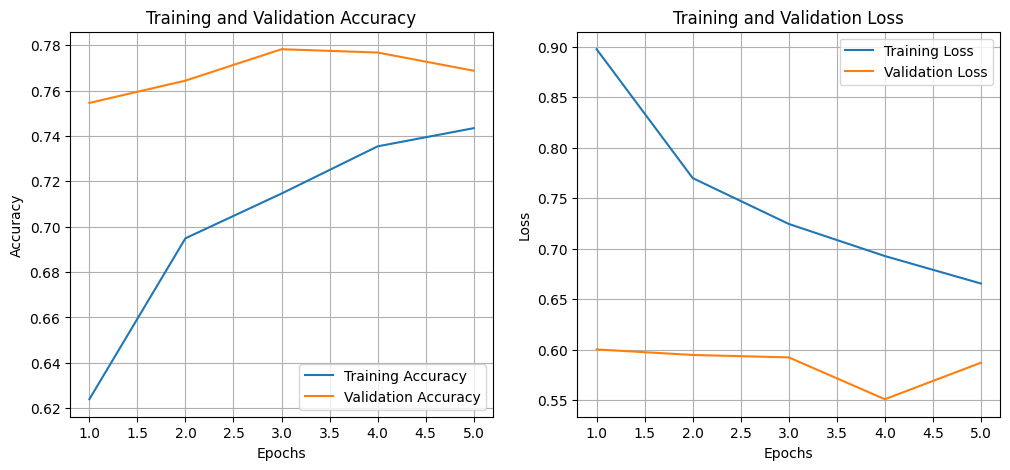

In [57]:
plot_history(history_s2)

##**Tải model**

In [76]:
tokenizer1 = AutoTokenizer.from_pretrained(BEST_MODEL_PATH1)
model1 = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH1)
model1.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

##**Đánh giá trên tập dữ liệu kiểm thử**

In [65]:
test_accuracy, test_report, _ = eval_model(
    model1,
    test_loader,
    device,
    target_names
)

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(test_report)

Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Accuracy: 0.7676620538965768 - Report:               precision    recall  f1-score   support

         POS       0.68      0.82      0.75       642
         NEU       0.39      0.36      0.38       440
         NEG       0.91      0.85      0.88      1664

    accuracy                           0.77      2746
   macro avg       0.66      0.68      0.67      2746
weighted avg       0.77      0.77      0.77      2746

Final Test Accuracy: 0.7677

Test Classification Report:
              precision    recall  f1-score   support

         POS       0.68      0.82      0.75       642
         NEU       0.39      0.36      0.38       440
         NEG       0.91      0.85      0.88      1664

    accuracy                           0.77      2746
   macro avg       0.66      0.68      0.67      2746
weighted avg       0.77      0.77      0.77      2746



##**Đánh giá bằng LLMs**

In [77]:
df_preds = get_test_predictions(model1, test_loader, device)
llm_evaluation_results = llm_evaluate_classification(df_preds, sample_size=30)
print(llm_evaluation_results)

df_ket_qua = pd.read_csv("llm_evaluation_misclassified.csv")

excel_filename = "/content/drive/MyDrive/NLP/encoder-only/ket_qua_danh_gia_gemini1.xlsx"
df_ket_qua.to_excel(excel_filename, index=False)

Generating Predictions:   0%|          | 0/172 [00:00<?, ?it/s]

LLM Scoring (30 mẫu): 0it [00:00, ?it/s]


--- ĐÁNH GIÁ LLM HOÀN TẤT ---
Đã chấm điểm và lưu 30 mẫu vào 'llm_evaluation_misclassified.csv'.
    Độ_Khó  Lỗi_Do_Dữ_Liệu                                              Lý_do  \
0        5               1  Bình luận gốc "Shop phục vụ tốt, áo đẹp, hướng...   
1        4               1  Bình luận chứa cả ý tích cực rõ ràng ('đầm đẹp...   
2        4               1  Mô hình đã tập trung vào cụm từ phủ định và ý ...   
3        3               0  Bình luận mô tả việc nhận sai sản phẩm (đặt áo...   
4        4               1  Bình luận chứa cụm từ "ko đẹp" (không đẹp) vốn...   
5        4               1  Bình luận 'Minhk đã nhận được hàng.' là một câ...   
6        4               1  Bình luận chứa cả hai sắc thái: tích cực ("Ngh...   
7        4               1  Bình luận chứa cả sắc thái tích cực mạnh mẽ ("...   
8        4               1  Bình luận chứa cảm xúc hỗn hợp và mơ hồ. Có ha...   
9        3               0  Bình luận chứa cả khía cạnh tích cực/trung lập...   
10       3 

#**Kiểm thử**

In [69]:
predict("tôi rất thích món này ", model, tokenizer, device, MAX_LENGTH)

'Positive'

In [68]:
predict("sản phẩm hơi tệ", model1, tokenizer, device, MAX_LENGTH)

'Negative'